# I. Importing the required libraries

In [99]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

import warnings
warnings.filterwarnings('ignore')

# II. Reading the data

In [100]:
dir_list=[]
for folder in os.listdir('data/'):
    if folder[0]!=".":
        dir_list.append(folder)

dir_list.sort()
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [101]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [102]:
print (len(data_df))
data_df.head()

2452


,path,source,actor,gender,intensity,statement,repetition,emotion
0,data/Actor_01/03-01-08-02-02-01-01.wav,1,1,male,1,1,0,8
1,data/Actor_01/03-01-08-01-01-01-01.wav,1,1,male,0,0,0,8
2,data/Actor_01/03-01-05-01-02-01-01.wav,1,1,male,0,1,0,5
3,data/Actor_01/03-02-03-02-02-02-01.wav,2,1,male,1,1,1,3
4,data/Actor_01/03-01-06-01-02-02-01.wav,1,1,male,0,1,1,6


# III. Plotting the audio file's waveform and its spectrogram

In [103]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

data/Actor_10/03-01-03-01-02-02-10.wav


(22050,
 array([-1.1454663e-05, -4.0161399e-06,  1.3158753e-05, ...,
         6.0362415e-04, -5.5820190e-05,  0.0000000e+00], dtype=float32))

In [104]:
len(samples), sample_rate

(73574, 22050)

In [105]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [106]:
sample_rate/ len(samples)

0.29969826297333296

Text(0.5, 0, 'Seconds')

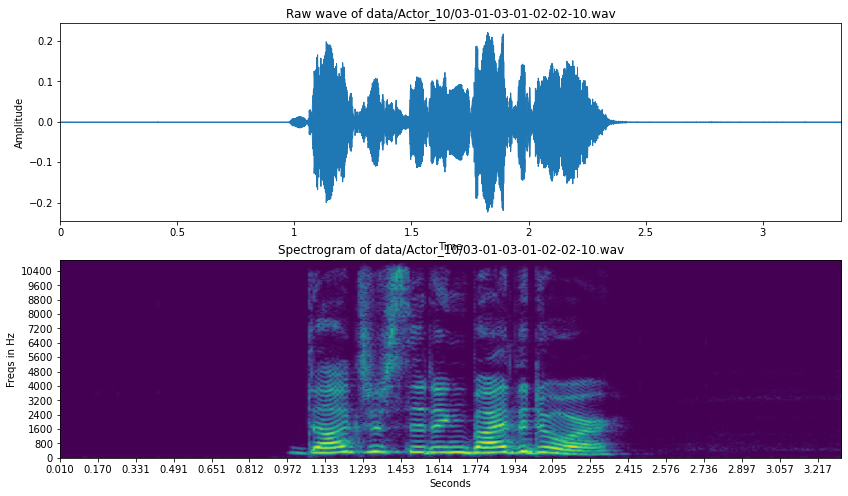

In [107]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [108]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [109]:
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 2.1327467e-05,  1.8847053e-05,  1.4876525e-04, ...,
         4.0795762e-04,  3.7352598e-05, -2.5286991e-04], dtype=float32),
 array([21504, 52736]))

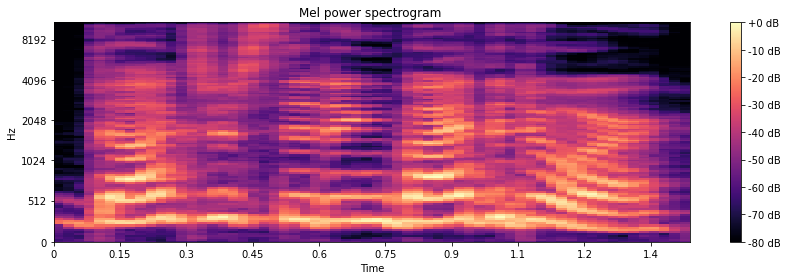

In [110]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

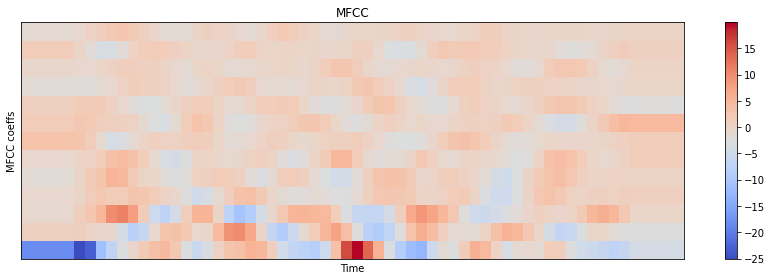

In [111]:

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [112]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [113]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [114]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [115]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

2452

In [116]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

2452

In [117]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

2452

In [118]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

2452

In [119]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-08-02-02-01-01.wav,1,1,male,1,1,0,8,male_none
1,data/Actor_01/03-01-08-01-01-01-01.wav,1,1,male,0,0,0,8,male_none
2,data/Actor_01/03-01-05-01-02-01-01.wav,1,1,male,0,1,0,5,male_negative
3,data/Actor_01/03-02-03-02-02-02-01.wav,2,1,male,1,1,1,3,male_positive
4,data/Actor_01/03-01-06-01-02-02-01.wav,1,1,male,0,1,1,6,male_negative


In [120]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_positive', 'female_positive',
       'male_none', 'female_none'],
      dtype='object')


In [121]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

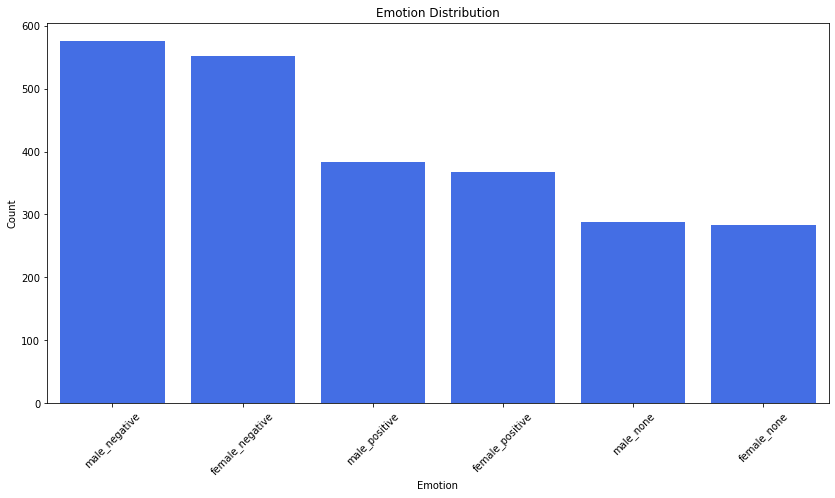

In [122]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [123]:
# Female Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
data2_df = data2_df[data2_df.label != "male_happy"]
data2_df = data2_df[data2_df.label != "male_angry"]
data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 22]
tmp2 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

760


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_02/03-01-06-01-02-02-02.wav,1,2,female,0,1,1,6,female_negative
1,data/Actor_02/03-02-03-02-02-02-02.wav,2,2,female,1,1,1,3,female_positive
2,data/Actor_02/03-01-05-01-02-01-02.wav,1,2,female,0,1,0,5,female_negative
3,data/Actor_02/03-01-05-02-01-01-02.wav,1,2,female,1,0,0,5,female_negative
4,data/Actor_02/03-02-03-01-01-02-02.wav,2,2,female,0,0,1,3,female_positive


In [124]:
# Male Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

800


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-01-05-01-02-01-01.wav,1,1,male,0,1,0,5,male_negative
1,data/Actor_01/03-02-03-02-02-02-01.wav,2,1,male,1,1,1,3,male_positive
2,data/Actor_01/03-01-06-01-02-02-01.wav,1,1,male,0,1,1,6,male_negative
3,data/Actor_01/03-01-06-02-01-02-01.wav,1,1,male,1,0,1,6,male_negative
4,data/Actor_01/03-02-03-01-01-02-01.wav,2,1,male,0,0,1,3,male_positive


In [125]:
print (len(data3_df))
data3_df.head()

160


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_21/03-01-06-01-01-02-21.wav,1,21,male,0,0,1,6,male_negative
1,data/Actor_21/03-02-03-02-01-02-21.wav,2,21,male,1,0,1,3,male_positive
2,data/Actor_21/03-01-05-01-01-01-21.wav,1,21,male,0,0,0,5,male_negative
3,data/Actor_21/03-01-05-02-02-01-21.wav,1,21,male,1,1,0,5,male_negative
4,data/Actor_21/03-02-03-01-02-02-21.wav,2,21,male,0,1,1,3,male_positive


# VI. Getting the features of audio files using librosa

In [126]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 800/800 [00:32<00:00, 24.90it/s]


In [128]:
data.head()

,feature
0,"[-55.663086, -56.170334, -56.157845, -54.66347..."
1,"[-42.570976, -40.83292, -43.351402, -45.777306..."
2,"[-63.523525, -63.523525, -63.523525, -63.52352..."
3,"[-43.19739, -44.238605, -43.996212, -44.13236,..."
4,"[-57.01109, -56.533325, -55.997982, -56.788414..."


In [129]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [130]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336
1,-42.570976,-40.832920,-43.351402,-45.777306,-45.316982,-46.159874,-46.878906,-49.235023,-50.700127,-51.749371,...,-27.539379,-27.175976,-27.083834,-27.648394,-28.129354,-29.144192,-28.927479,-28.839302,-19.425776,-12.953273
2,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.889992,-63.725601,-62.940964,-63.046486,-63.523525,-63.523525,-63.523525,-62.370125,-61.950619,-63.523525
3,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,-40.030666,-40.667130,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612
4,-57.011089,-56.533325,-55.997982,-56.788414,-59.220562,-49.699871,-44.694660,-45.418980,-46.613422,-45.225151,...,-34.735371,-33.910206,-33.675377,-33.441998,-33.803959,-35.545387,-38.820030,-41.839561,-41.200687,-38.540085


In [131]:
newdf = pd.concat([df3,labels], axis=1)

In [132]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

800

In [133]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,male_negative
1,-42.570976,-40.832920,-43.351402,-45.777306,-45.316982,-46.159874,-46.878906,-49.235023,-50.700127,-51.749371,...,-27.175976,-27.083834,-27.648394,-28.129354,-29.144192,-28.927479,-28.839302,-19.425776,-12.953273,male_positive
2,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940964,-63.046486,-63.523525,-63.523525,-63.523525,-62.370125,-61.950619,-63.523525,male_negative
3,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,-40.667130,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612,male_negative
4,-57.011089,-56.533325,-55.997982,-56.788414,-59.220562,-49.699871,-44.694660,-45.418980,-46.613422,-45.225151,...,-33.910206,-33.675377,-33.441998,-33.803959,-35.545387,-38.820030,-41.839561,-41.200687,-38.540085,male_positive
5,-42.991745,-42.991745,-42.845966,-42.267849,-40.690147,-40.163383,-40.072182,-42.603901,-41.733139,-41.410767,...,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,-42.991745,male_negative
6,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-33.816696,-33.924679,-34.541080,-34.753689,-36.417641,-36.057072,-35.067146,-27.525869,-20.673979,male_positive
7,-67.736153,-67.778015,-66.746140,-65.957878,-67.736153,-67.736153,-67.736153,-67.258682,-67.736153,-67.736153,...,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,-67.736153,male_negative
8,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,...,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,-61.560623,male_negative
9,-61.929478,-61.929478,-61.929478,-61.929478,-60.674362,-60.394733,-61.859238,-61.559097,-61.015480,-59.214947,...,-35.999203,-35.673229,-36.919624,-37.295956,-38.760563,-38.440575,-39.280315,-34.705284,-29.847410,male_positive


In [134]:
rnewdf.isnull().sum().sum()

2284

In [135]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,male_negative
1,-42.570976,-40.832920,-43.351402,-45.777306,-45.316982,-46.159874,-46.878906,-49.235023,-50.700127,-51.749371,...,-27.175976,-27.083834,-27.648394,-28.129354,-29.144192,-28.927479,-28.839302,-19.425776,-12.953273,male_positive
2,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940964,-63.046486,-63.523525,-63.523525,-63.523525,-62.370125,-61.950619,-63.523525,male_negative
3,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,-40.667130,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612,male_negative
4,-57.011089,-56.533325,-55.997982,-56.788414,-59.220562,-49.699871,-44.694660,-45.418980,-46.613422,-45.225151,...,-33.910206,-33.675377,-33.441998,-33.803959,-35.545387,-38.820030,-41.839561,-41.200687,-38.540085,male_positive


# VII. Data Augmentation

In [136]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




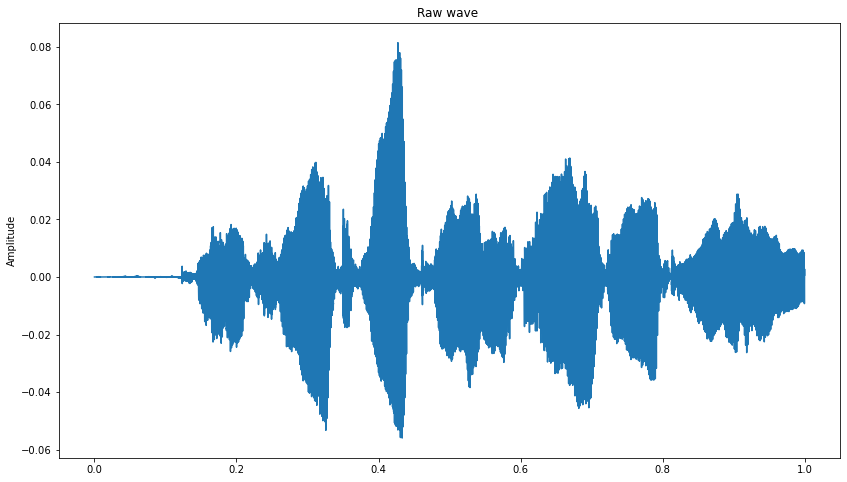

In [137]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

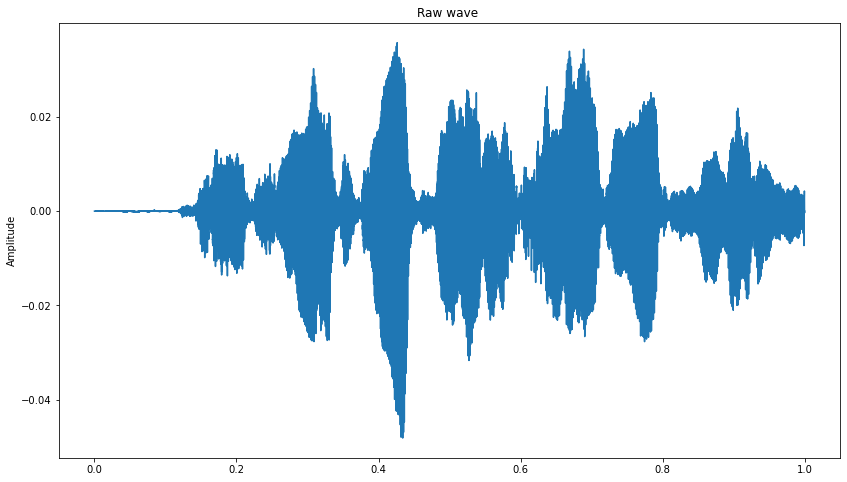

In [138]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [139]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 800/800 [00:33<00:00, 24.15it/s]


In [140]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 800/800 [02:28<00:00,  5.40it/s]


In [141]:
len(syn_data1), len(syn_data2) 

(800, 800)

In [142]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [143]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

800

In [144]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-45.550076,-44.168158,-46.764224,-46.861042,-45.918647,-46.758787,-45.110513,-46.098121,-47.971222,-48.332635,...,-44.785260,-45.255352,-46.299158,-47.244819,-45.342101,-43.824150,-43.820659,-44.640986,-47.425757,male_negative
1,-42.360201,-39.457742,-38.650835,-39.356838,-39.437828,-38.141523,-39.003223,-38.459409,-39.036457,-42.935499,...,-25.814433,-25.899200,-25.491662,-25.173326,-24.858575,-25.565040,-26.215296,-18.646174,-12.281478,male_positive
2,-63.425653,-62.676144,-63.321304,-63.134807,-62.537767,-62.328251,-62.601811,-62.693476,-62.556414,-62.755214,...,-61.439141,-60.790989,-61.627526,-61.419975,-60.801462,-62.525989,-60.788802,-60.455625,-62.621475,male_negative
3,-43.224934,-44.128096,-43.847770,-44.102314,-44.364444,-44.313717,-44.169900,-44.396457,-43.736084,-43.550187,...,-40.756041,-38.604554,-38.188668,-39.204256,-41.085381,-39.814436,-41.471977,-43.405987,-43.237364,male_negative
4,-52.178869,-52.914267,-51.394144,-51.529964,-54.205272,-48.229235,-43.486603,-44.122489,-46.307078,-44.509622,...,-33.306636,-33.253276,-32.700626,-32.889669,-34.662280,-36.643104,-39.109086,-39.847946,-38.343726,male_positive


In [145]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

800

In [146]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-56.765327,-58.239488,-57.679331,-56.471474,-57.896139,-58.507637,-58.507637,-58.507637,-58.507637,-58.507637,...,-58.507637,-58.507637,-58.507637,-58.450716,-58.161481,-57.898235,-58.166135,-58.286223,-58.019411,male_negative
1,-45.281285,-44.593586,-48.291690,-50.052313,-49.500955,-49.643588,-50.982807,-52.728082,-54.646303,-54.799596,...,-32.643449,-33.664474,-33.376395,-33.900560,-34.036938,-30.316533,-25.485028,-21.207073,-20.505787,male_positive
2,-65.316702,-65.316702,-65.316702,-65.316702,-65.316702,-64.892301,-64.730655,-65.204757,-65.316702,-65.316702,...,-65.400456,-65.361107,-65.071423,-65.316702,-65.325893,-64.712220,-63.516730,-64.532251,-65.330570,male_negative
3,-44.749680,-47.518500,-50.344466,-50.642204,-51.151901,-51.618296,-51.234730,-51.652370,-51.410163,-51.405562,...,-44.736169,-45.446914,-44.175209,-46.189454,-45.685181,-46.834516,-47.118573,-47.762621,-50.287932,male_negative
4,-57.524851,-57.593045,-59.531144,-60.262799,-55.982978,-51.313322,-46.777464,-47.102192,-48.336510,-47.244731,...,-34.313288,-34.464686,-35.621491,-35.026041,-37.035576,-40.775540,-44.013194,-44.879700,-42.427629,male_positive


In [147]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,...,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,male_negative
1,-42.570976,-40.832920,-43.351402,-45.777306,-45.316982,-46.159874,-46.878906,-49.235023,-50.700127,-51.749371,...,-27.175976,-27.083834,-27.648394,-28.129354,-29.144192,-28.927479,-28.839302,-19.425776,-12.953273,male_positive
2,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,...,-63.725601,-62.940964,-63.046486,-63.523525,-63.523525,-63.523525,-62.370125,-61.950619,-63.523525,male_negative
3,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,...,-40.667130,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612,male_negative
4,-57.011089,-56.533325,-55.997982,-56.788414,-59.220562,-49.699871,-44.694660,-45.418980,-46.613422,-45.225151,...,-33.910206,-33.675377,-33.441998,-33.803959,-35.545387,-38.820030,-41.839561,-41.200687,-38.540085,male_positive


In [148]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [149]:
y_train.value_counts()

male_negative    1152
male_positive     768
Name: label, dtype: int64

In [150]:
y_test.value_counts()

male_negative    288
male_positive    192
Name: label, dtype: int64

In [151]:
X_train.isna().sum().sum()

0

In [152]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [153]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [154]:
X_train.shape

(1920, 259)

# VIII. Changing dimension for CNN model

In [155]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [156]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [157]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [158]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [159]:
# Plotting Model Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_10 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_3 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_11 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 32, 256)          

In [160]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [161]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Train on 1920 samples, validate on 480 samples
Epoch 1/700
1920/1920 [==============================] - 52s 27ms/step - loss: 0.6622 - accuracy: 0.6182 - fscore: 0.6182 - val_loss: 0.6839 - val_accuracy: 0.5813 - val_fscore: 0.5812
Epoch 2/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.6348 - accuracy: 0.6359 - fscore: 0.6359 - val_loss: 0.6616 - val_accuracy: 0.6083 - val_fscore: 0.6083
Epoch 3/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.6218 - accuracy: 0.6469 - fscore: 0.6469 - val_loss: 0.6420 - val_accuracy: 0.6458 - val_fscore: 0.6458
Epoch 4/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.6198 - accuracy: 0.6464 - fscore: 0.6464 - val_loss: 0.6277 - val_accuracy: 0.6396 - val_fscore: 0.6396
Epoch 5/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.6116 - accuracy: 0.6651 - fscore: 0.6651 - val_loss: 0.6236 - val_accuracy: 0.6625 - val_fscore: 0.6625
Epoch 6/700
1920/1920 [=====

Epoch 45/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.4914 - accuracy: 0.7641 - fscore: 0.7641 - val_loss: 0.5531 - val_accuracy: 0.7521 - val_fscore: 0.7521
Epoch 46/700
1920/1920 [==============================] - 49s 26ms/step - loss: 0.4833 - accuracy: 0.7823 - fscore: 0.7823 - val_loss: 0.5529 - val_accuracy: 0.7625 - val_fscore: 0.7625
Epoch 47/700
1920/1920 [==============================] - 55s 29ms/step - loss: 0.4802 - accuracy: 0.7880 - fscore: 0.7880 - val_loss: 0.5547 - val_accuracy: 0.7271 - val_fscore: 0.7271
Epoch 48/700
1920/1920 [==============================] - 62s 32ms/step - loss: 0.4854 - accuracy: 0.7708 - fscore: 0.7708 - val_loss: 0.5974 - val_accuracy: 0.6375 - val_fscore: 0.6375
Epoch 49/700
1920/1920 [==============================] - 49s 25ms/step - loss: 0.4806 - accuracy: 0.7766 - fscore: 0.7766 - val_loss: 0.5535 - val_accuracy: 0.7396 - val_fscore: 0.7396
Epoch 50/700
1920/1920 [==============================] - 49s 26ms/ste

1920/1920 [==============================] - 49s 26ms/step - loss: 0.3712 - accuracy: 0.8609 - fscore: 0.8609 - val_loss: 0.5170 - val_accuracy: 0.7667 - val_fscore: 0.7667
Epoch 90/700
1920/1920 [==============================] - 56s 29ms/step - loss: 0.3721 - accuracy: 0.8484 - fscore: 0.8484 - val_loss: 0.4899 - val_accuracy: 0.7417 - val_fscore: 0.7417
Epoch 91/700
1920/1920 [==============================] - 49s 26ms/step - loss: 0.3595 - accuracy: 0.8604 - fscore: 0.8604 - val_loss: 0.5199 - val_accuracy: 0.7583 - val_fscore: 0.7583
Epoch 92/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.3688 - accuracy: 0.8542 - fscore: 0.8542 - val_loss: 0.4838 - val_accuracy: 0.7958 - val_fscore: 0.7958
Epoch 93/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.3664 - accuracy: 0.8526 - fscore: 0.8526 - val_loss: 0.4734 - val_accuracy: 0.7667 - val_fscore: 0.7667
Epoch 94/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.3

Epoch 133/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.2587 - accuracy: 0.9094 - fscore: 0.9094 - val_loss: 0.3952 - val_accuracy: 0.8438 - val_fscore: 0.8437
Epoch 134/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.2542 - accuracy: 0.9187 - fscore: 0.9187 - val_loss: 0.3976 - val_accuracy: 0.8313 - val_fscore: 0.8312
Epoch 135/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.2435 - accuracy: 0.9203 - fscore: 0.9203 - val_loss: 0.4111 - val_accuracy: 0.8042 - val_fscore: 0.8042
Epoch 136/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.2458 - accuracy: 0.9141 - fscore: 0.9141 - val_loss: 0.3886 - val_accuracy: 0.8438 - val_fscore: 0.8437
Epoch 137/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.2505 - accuracy: 0.9156 - fscore: 0.9156 - val_loss: 0.3939 - val_accuracy: 0.8271 - val_fscore: 0.8271
Epoch 138/700
1920/1920 [==============================] - 48s 25

Epoch 177/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.1676 - accuracy: 0.9479 - fscore: 0.9479 - val_loss: 0.3422 - val_accuracy: 0.8854 - val_fscore: 0.8854
Epoch 178/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.1550 - accuracy: 0.9589 - fscore: 0.9589 - val_loss: 0.3533 - val_accuracy: 0.8625 - val_fscore: 0.8625
Epoch 179/700
1920/1920 [==============================] - 54s 28ms/step - loss: 0.1535 - accuracy: 0.9594 - fscore: 0.9594 - val_loss: 0.3316 - val_accuracy: 0.8438 - val_fscore: 0.8437
Epoch 180/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.1628 - accuracy: 0.9563 - fscore: 0.9563 - val_loss: 0.3113 - val_accuracy: 0.8875 - val_fscore: 0.8875
Epoch 181/700
1920/1920 [==============================] - 52s 27ms/step - loss: 0.1610 - accuracy: 0.9583 - fscore: 0.9583 - val_loss: 0.3556 - val_accuracy: 0.8250 - val_fscore: 0.8250
Epoch 182/700
1920/1920 [==============================] - 50s 26

Epoch 221/700
1920/1920 [==============================] - 45s 24ms/step - loss: 0.0987 - accuracy: 0.9766 - fscore: 0.9766 - val_loss: 0.2692 - val_accuracy: 0.9021 - val_fscore: 0.9021
Epoch 222/700
1920/1920 [==============================] - 45s 24ms/step - loss: 0.1037 - accuracy: 0.9766 - fscore: 0.9766 - val_loss: 0.3067 - val_accuracy: 0.8729 - val_fscore: 0.8729
Epoch 223/700
1920/1920 [==============================] - 45s 24ms/step - loss: 0.1065 - accuracy: 0.9703 - fscore: 0.9703 - val_loss: 0.2486 - val_accuracy: 0.9292 - val_fscore: 0.9292
Epoch 224/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.1061 - accuracy: 0.9708 - fscore: 0.9708 - val_loss: 0.2774 - val_accuracy: 0.8938 - val_fscore: 0.8938
Epoch 225/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0968 - accuracy: 0.9760 - fscore: 0.9760 - val_loss: 0.2684 - val_accuracy: 0.8958 - val_fscore: 0.8958
Epoch 226/700
1920/1920 [==============================] - 50s 26

Epoch 265/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.0677 - accuracy: 0.9849 - fscore: 0.9849 - val_loss: 0.2247 - val_accuracy: 0.9417 - val_fscore: 0.9417
Epoch 266/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0680 - accuracy: 0.9880 - fscore: 0.9880 - val_loss: 0.2363 - val_accuracy: 0.9146 - val_fscore: 0.9146
Epoch 267/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0688 - accuracy: 0.9828 - fscore: 0.9828 - val_loss: 0.2336 - val_accuracy: 0.9312 - val_fscore: 0.9312
Epoch 268/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0733 - accuracy: 0.9812 - fscore: 0.9812 - val_loss: 0.2630 - val_accuracy: 0.8813 - val_fscore: 0.8813
Epoch 269/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0740 - accuracy: 0.9823 - fscore: 0.9823 - val_loss: 0.2187 - val_accuracy: 0.9333 - val_fscore: 0.9333
Epoch 270/700
1920/1920 [==============================] - 46s 24

Epoch 309/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.0556 - accuracy: 0.9885 - fscore: 0.9885 - val_loss: 0.2019 - val_accuracy: 0.9271 - val_fscore: 0.9271
Epoch 310/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0490 - accuracy: 0.9911 - fscore: 0.9911 - val_loss: 0.2104 - val_accuracy: 0.9354 - val_fscore: 0.9354
Epoch 311/700
1920/1920 [==============================] - 61s 32ms/step - loss: 0.0545 - accuracy: 0.9859 - fscore: 0.9859 - val_loss: 0.1916 - val_accuracy: 0.9438 - val_fscore: 0.9438
Epoch 312/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0507 - accuracy: 0.9896 - fscore: 0.9896 - val_loss: 0.2081 - val_accuracy: 0.9146 - val_fscore: 0.9146
Epoch 313/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.0518 - accuracy: 0.9906 - fscore: 0.9906 - val_loss: 0.1852 - val_accuracy: 0.9458 - val_fscore: 0.9458
Epoch 314/700
1920/1920 [==============================] - 47s 25

Epoch 353/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0436 - accuracy: 0.9917 - fscore: 0.9917 - val_loss: 0.2157 - val_accuracy: 0.9104 - val_fscore: 0.9104
Epoch 354/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0390 - accuracy: 0.9937 - fscore: 0.9937 - val_loss: 0.1865 - val_accuracy: 0.9438 - val_fscore: 0.9438
Epoch 355/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0434 - accuracy: 0.9906 - fscore: 0.9906 - val_loss: 0.2161 - val_accuracy: 0.9292 - val_fscore: 0.9292
Epoch 356/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0392 - accuracy: 0.9932 - fscore: 0.9932 - val_loss: 0.1849 - val_accuracy: 0.9271 - val_fscore: 0.9271
Epoch 357/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.0385 - accuracy: 0.9927 - fscore: 0.9927 - val_loss: 0.1867 - val_accuracy: 0.9333 - val_fscore: 0.9333
Epoch 358/700
1920/1920 [==============================] - 46s 24

Epoch 397/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0330 - accuracy: 0.9964 - fscore: 0.9964 - val_loss: 0.1740 - val_accuracy: 0.9417 - val_fscore: 0.9417
Epoch 398/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0322 - accuracy: 0.9953 - fscore: 0.9953 - val_loss: 0.1787 - val_accuracy: 0.9438 - val_fscore: 0.9438
Epoch 399/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0322 - accuracy: 0.9937 - fscore: 0.9937 - val_loss: 0.1698 - val_accuracy: 0.9458 - val_fscore: 0.9458
Epoch 400/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0287 - accuracy: 0.9958 - fscore: 0.9958 - val_loss: 0.2010 - val_accuracy: 0.9312 - val_fscore: 0.9312
Epoch 401/700
1920/1920 [==============================] - 46s 24ms/step - loss: 0.0321 - accuracy: 0.9937 - fscore: 0.9937 - val_loss: 0.1930 - val_accuracy: 0.9396 - val_fscore: 0.9396
Epoch 402/700
1920/1920 [==============================] - 46s 24

Epoch 441/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.0266 - accuracy: 0.9958 - fscore: 0.9958 - val_loss: 0.1676 - val_accuracy: 0.9438 - val_fscore: 0.9438
Epoch 442/700
1920/1920 [==============================] - 49s 26ms/step - loss: 0.0292 - accuracy: 0.9937 - fscore: 0.9937 - val_loss: 0.1583 - val_accuracy: 0.9500 - val_fscore: 0.9500
Epoch 443/700
1920/1920 [==============================] - 47s 25ms/step - loss: 0.0269 - accuracy: 0.9953 - fscore: 0.9953 - val_loss: 0.1657 - val_accuracy: 0.9375 - val_fscore: 0.9375
Epoch 444/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0232 - accuracy: 0.9979 - fscore: 0.9979 - val_loss: 0.1651 - val_accuracy: 0.9438 - val_fscore: 0.9438
Epoch 445/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.0280 - accuracy: 0.9948 - fscore: 0.9948 - val_loss: 0.1690 - val_accuracy: 0.9375 - val_fscore: 0.9375
Epoch 446/700
1920/1920 [==============================] - 50s 26

Epoch 485/700
1920/1920 [==============================] - 51s 27ms/step - loss: 0.0283 - accuracy: 0.9932 - fscore: 0.9932 - val_loss: 0.1709 - val_accuracy: 0.9396 - val_fscore: 0.9396
Epoch 486/700
1920/1920 [==============================] - 83s 43ms/step - loss: 0.0208 - accuracy: 0.9979 - fscore: 0.9979 - val_loss: 0.1709 - val_accuracy: 0.9292 - val_fscore: 0.9292
Epoch 487/700
1920/1920 [==============================] - 53s 28ms/step - loss: 0.0216 - accuracy: 0.9974 - fscore: 0.9974 - val_loss: 0.1699 - val_accuracy: 0.9417 - val_fscore: 0.9417
Epoch 488/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0226 - accuracy: 0.9984 - fscore: 0.9984 - val_loss: 0.1775 - val_accuracy: 0.9312 - val_fscore: 0.9312
Epoch 489/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0218 - accuracy: 0.9969 - fscore: 0.9969 - val_loss: 0.1881 - val_accuracy: 0.9396 - val_fscore: 0.9396
Epoch 490/700
1920/1920 [==============================] - 50s 26

Epoch 529/700
1920/1920 [==============================] - 51s 27ms/step - loss: 0.0207 - accuracy: 0.9974 - fscore: 0.9974 - val_loss: 0.1723 - val_accuracy: 0.9417 - val_fscore: 0.9417
Epoch 530/700
1920/1920 [==============================] - 49s 25ms/step - loss: 0.0200 - accuracy: 0.9984 - fscore: 0.9984 - val_loss: 0.1632 - val_accuracy: 0.9500 - val_fscore: 0.9500
Epoch 531/700
1920/1920 [==============================] - 54s 28ms/step - loss: 0.0199 - accuracy: 0.9974 - fscore: 0.9974 - val_loss: 0.1560 - val_accuracy: 0.9458 - val_fscore: 0.9458
Epoch 532/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.0236 - accuracy: 0.9953 - fscore: 0.9953 - val_loss: 0.1625 - val_accuracy: 0.9438 - val_fscore: 0.9438
Epoch 533/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0220 - accuracy: 0.9974 - fscore: 0.9974 - val_loss: 0.1561 - val_accuracy: 0.9375 - val_fscore: 0.9375
Epoch 534/700
1920/1920 [==============================] - 49s 25

Epoch 573/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0182 - accuracy: 0.9984 - fscore: 0.9984 - val_loss: 0.1590 - val_accuracy: 0.9333 - val_fscore: 0.9333
Epoch 574/700
1920/1920 [==============================] - 52s 27ms/step - loss: 0.0206 - accuracy: 0.9969 - fscore: 0.9969 - val_loss: 0.1624 - val_accuracy: 0.9396 - val_fscore: 0.9396
Epoch 575/700
1920/1920 [==============================] - 53s 28ms/step - loss: 0.0194 - accuracy: 0.9948 - fscore: 0.9948 - val_loss: 0.1620 - val_accuracy: 0.9396 - val_fscore: 0.9396
Epoch 576/700
1920/1920 [==============================] - 51s 27ms/step - loss: 0.0175 - accuracy: 0.9979 - fscore: 0.9979 - val_loss: 0.1597 - val_accuracy: 0.9375 - val_fscore: 0.9375
Epoch 577/700
1920/1920 [==============================] - 53s 28ms/step - loss: 0.0198 - accuracy: 0.9969 - fscore: 0.9969 - val_loss: 0.1639 - val_accuracy: 0.9458 - val_fscore: 0.9458
Epoch 578/700
1920/1920 [==============================] - 50s 26

Epoch 617/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0178 - accuracy: 0.9984 - fscore: 0.9984 - val_loss: 0.1593 - val_accuracy: 0.9312 - val_fscore: 0.9312
Epoch 618/700
1920/1920 [==============================] - 49s 26ms/step - loss: 0.0222 - accuracy: 0.9958 - fscore: 0.9958 - val_loss: 0.1550 - val_accuracy: 0.9458 - val_fscore: 0.9458
Epoch 619/700
1920/1920 [==============================] - 49s 26ms/step - loss: 0.0205 - accuracy: 0.9953 - fscore: 0.9953 - val_loss: 0.1592 - val_accuracy: 0.9417 - val_fscore: 0.9417
Epoch 620/700
1920/1920 [==============================] - 49s 26ms/step - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.0000 - val_loss: 0.1566 - val_accuracy: 0.9479 - val_fscore: 0.9479
Epoch 621/700
1920/1920 [==============================] - 49s 25ms/step - loss: 0.0164 - accuracy: 0.9974 - fscore: 0.9974 - val_loss: 0.1678 - val_accuracy: 0.9229 - val_fscore: 0.9229
Epoch 622/700
1920/1920 [==============================] - 53s 28

Epoch 661/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.0188 - accuracy: 0.9964 - fscore: 0.9964 - val_loss: 0.1532 - val_accuracy: 0.9438 - val_fscore: 0.9438
Epoch 662/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.0206 - accuracy: 0.9969 - fscore: 0.9969 - val_loss: 0.1597 - val_accuracy: 0.9333 - val_fscore: 0.9333
Epoch 663/700
1920/1920 [==============================] - 48s 25ms/step - loss: 0.0178 - accuracy: 0.9958 - fscore: 0.9958 - val_loss: 0.1526 - val_accuracy: 0.9417 - val_fscore: 0.9417
Epoch 664/700
1920/1920 [==============================] - 50s 26ms/step - loss: 0.0172 - accuracy: 0.9969 - fscore: 0.9969 - val_loss: 0.1556 - val_accuracy: 0.9354 - val_fscore: 0.9354
Epoch 665/700
1920/1920 [==============================] - 47s 24ms/step - loss: 0.0127 - accuracy: 0.9995 - fscore: 0.9995 - val_loss: 0.1533 - val_accuracy: 0.9396 - val_fscore: 0.9396
Epoch 666/700
1920/1920 [==============================] - 48s 25

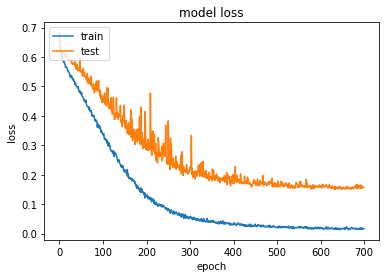

In [162]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [163]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [164]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 94.38%


# X. Predicting emotions on the test data

In [165]:
len(data3_df)

160

In [166]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 160/160 [00:05<00:00, 28.89it/s]


In [167]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

160/160 [==============================] - 2s 14ms/step


In [168]:
preds

array([[2.67892536e-02, 9.73210812e-01],
       [1.78551290e-03, 9.98214483e-01],
       [4.57952559e-01, 5.42047501e-01],
       [3.78938735e-01, 6.21061325e-01],
       [3.16758698e-04, 9.99683261e-01],
       [9.99086618e-01, 9.13383556e-04],
       [9.76628996e-03, 9.90233660e-01],
       [9.54164743e-01, 4.58352454e-02],
       [3.56570274e-01, 6.43429697e-01],
       [7.48360395e-01, 2.51639634e-01],
       [9.51741993e-01, 4.82580811e-02],
       [4.87351358e-01, 5.12648642e-01],
       [9.88116741e-01, 1.18832281e-02],
       [6.99819922e-01, 3.00180018e-01],
       [9.97914851e-01, 2.08511855e-03],
       [1.02228381e-01, 8.97771597e-01],
       [8.84820521e-01, 1.15179531e-01],
       [1.22080415e-01, 8.77919614e-01],
       [9.14397955e-01, 8.56020823e-02],
       [9.12143409e-01, 8.78566429e-02],
       [7.96684176e-02, 9.20331597e-01],
       [7.99012840e-01, 2.00987175e-01],
       [9.87883389e-01, 1.21165495e-02],
       [1.90677401e-02, 9.80932236e-01],
       [9.393074

In [169]:
preds1=preds.argmax(axis=1)

In [170]:
preds1

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0])

In [171]:
abc = preds1.astype(int).flatten()

In [172]:
predictions = (lb.inverse_transform((abc)))

In [173]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_negative
6,male_positive
7,male_negative
8,male_positive
9,male_negative


In [174]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [175]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_negative
1,male_positive
2,male_negative
3,male_negative
4,male_positive
5,male_negative
6,male_negative
7,male_positive
8,male_positive
9,male_negative


In [176]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [177]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_positive
21,male_negative,male_negative
22,male_positive,male_negative
23,male_positive,male_positive
24,male_negative,male_negative
25,male_negative,male_negative
26,male_positive,male_positive
27,male_negative,male_negative
28,male_negative,male_negative
29,male_positive,male_positive


In [178]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,96
male_positive,64


In [179]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_negative,92
male_positive,68


In [180]:
finaldf.to_csv('Predictions.csv', index=False)

In [181]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [182]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

67.5

In [183]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

66.47324306898776

In [184]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[68, 28],
       [24, 40]])

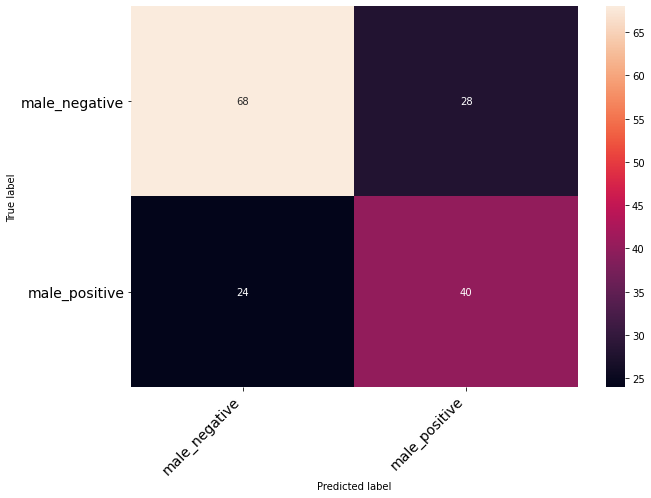

In [185]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)